In [1]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler, Estimator
# from qiskit.primitives import Estimator
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit import  Aer
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider

from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import os


import LHC_QML_module as lqm

In [2]:
# settings to tune

seed = 123
# Features to train on
training_feature_keys = [
    "f_mass4l",
    # "f_eta4l",
    "f_Z2mass",
    "f_Z1mass",
]

save_folder = os.path.join("saved", "model1g3-qiskit-estimator-noise")

batch_size = 2
n_epochs = 1

train_data_size = 80
test_data_size = 80
valid_data_size = 40
total_datasize = train_data_size + test_data_size + valid_data_size
half_datasize = total_datasize // 2 # 80 signal and 80 backgrounds
# opt = NesterovMomentumOptimizer(0.1)
# opt = SPSAOptimizer(maxiter=200)

is_local_simulator = True

spsa_alpha = 0.8
spsa_gamma = 0.101
spsa_c     = 0.3
spsa_A     = 1.
spsa_a1    = 0.6
spsa_a     = spsa_a1 * (spsa_A + 1) ** spsa_alpha

In [3]:
np.random.seed(seed)

if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

This notebook may overwrite previous results in the saved/model1g3-qiskit-estimator-noise directory


In [4]:
n_qubits = 3
num_layers = 5

# weights_init = 0.5 * np.random.randn(num_layers, n_qubits, requires_grad=True)
weights_init = 0.5 * np.random.randn(num_layers , n_qubits)
weights_init = weights_init.flatten()

In [5]:
# IBMProvider.save_account(token='e97825248109ea6aced9706dd63e70d9bbc183607f0ae887d0565d17a519c234550ad76748d4585143f8add8dfc4b42f182e5ca74c4e39d9576a1eff42e65b4f')
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)



In [6]:
qc_template = QuantumCircuit(n_qubits)

par_inputs = ParameterVector("input", n_qubits)
par_weights = ParameterVector("weights", num_layers * n_qubits)

for i in range(n_qubits):
    qc_template.rx(par_inputs[i], i)

for i in range(n_qubits):
    qc_template.ry(par_weights[i], i)

for i in range(n_qubits):
    qc_template.cx(i, (i+1)%n_qubits)

for i in range(n_qubits):
    qc_template.rz(par_weights[i+3], i)

for i in range(n_qubits):
    qc_template.cx(i, (i+1)%n_qubits)

for i in range(n_qubits):
    qc_template.rx(par_weights[i+6], i)

for i in range(n_qubits):
    qc_template.cx(i, (i+1)%n_qubits)

for i in range(n_qubits):
    qc_template.rz(par_weights[i+9], i)

for i in range(n_qubits):
    qc_template.cx(i, (i+1)%n_qubits)

for i in range(n_qubits):
    qc_template.rz(par_weights[i+12], i)

for i in range(n_qubits):
    qc_template.cx(i, (i+1)%n_qubits)


# qc_template.measure_all()
obs = SparsePauliOp("XXI")

In [7]:
qc_template.draw()

┌──────────────┐┌────────────────┐          ┌───┐┌────────────────┐     »
q_0: ┤ Rx(input[0]) ├┤ Ry(weights[0]) ├──■───────┤ X ├┤ Rz(weights[3]) ├──■──»
     ├──────────────┤├────────────────┤┌─┴─┐     └─┬─┘├────────────────┤┌─┴─┐»
q_1: ┤ Rx(input[1]) ├┤ Ry(weights[1]) ├┤ X ├──■────┼──┤ Rz(weights[4]) ├┤ X ├»
     ├──────────────┤├────────────────┤└───┘┌─┴─┐  │  ├────────────────┤└───┘»
q_2: ┤ Rx(input[2]) ├┤ Ry(weights[2]) ├─────┤ X ├──■──┤ Rz(weights[5]) ├─────»
     └──────────────┘└────────────────┘     └───┘     └────────────────┘     »
«          ┌───┐┌────────────────┐          ┌───┐ ┌────────────────┐          »
«q_0: ─────┤ X ├┤ Rx(weights[6]) ├──■───────┤ X ├─┤ Rz(weights[9]) ├──■───────»
«          └─┬─┘├────────────────┤┌─┴─┐     └─┬─┘┌┴────────────────┤┌─┴─┐     »
«q_1: ──■────┼──┤ Rx(weights[7]) ├┤ X ├──■────┼──┤ Rz(weights[10]) ├┤ X ├──■──»
«     ┌─┴─┐  │  ├────────────────┤└───┘┌─┴─┐  │  ├─────────────────┤└───┘┌─┴─┐»
«q_2: ┤ X ├──■──┤ Rx(weights[8]) ├─────┤ X ├──■──┤ Rz(weights[11]) ├─────┤ X ├»
«     └───┘     └────────────────┘     └───┘     └─────────────────┘     └───┘»
«     ┌───┐┌─────────────────┐          ┌───┐
«q_0: ┤ X ├┤ Rz(weights[12]) ├──■───────┤ X ├
«     └─┬─┘├─────────────────┤┌─┴─┐     └─┬─┘
«q_1: ──┼──┤ Rz(weights[13]) ├┤ X ├──■────┼──
«       │  ├─────────────────┤└───┘┌─┴─┐  │  
«q_2: ──■──┤ Rz(weights[14]) ├─────┤ X ├──■──
«          └─────────────────┘     └───┘

In [8]:
def loss(prob, label):
    # print(prob)
    return -np.mean(label*np.log(prob+1e-5)+(1-label)*np.log(1-prob+1e-5))

def accuracy(pred, label):
    return np.mean(np.isclose(pred,label))

def cost(weights, features, labels):
    probs = np.array([model(weights, f) for f in features])
    return loss(probs, labels)

In [9]:
signals_folder = "./../../qml-lhc/data/signal/higgs"
backgrounds_folder = "./../../qml-lhc/data/background/higgs"


use_pca = False



num_features = len(training_feature_keys)


# load data from files
signal_dict, background_dict, files_used = lqm.load_data(
    signals_folder, backgrounds_folder, training_feature_keys
)

# formats data for input into vqc
features, labels = lqm.format_data(signal_dict, background_dict)


n_signal_events = (labels == 1).sum()
n_background_events = (labels == 0).sum()

features_signal = features[(labels==1)]
features_background = features[(labels==0)]

np.random.shuffle(features_signal)
np.random.shuffle(features_background)

features = np.concatenate((features_signal[:half_datasize], features_background[:half_datasize]))
# labels = np.array([1]*half_datasize + [0]*half_datasize, requires_grad=False)
labels = np.array([1]*half_datasize + [0]*half_datasize)

# splits data into testing and training sets
train_features, rest_features, train_labels, rest_labels = train_test_split(
    features,
    labels,
    train_size=train_data_size,
    test_size=test_data_size + valid_data_size,
    random_state=seed,
    stratify=labels
)

# preprocess data (rescaling)
train_features, rest_features = lqm.preprocess_data(
    train_features, rest_features, use_pca, num_features, seed
)


valid_features, test_features, valid_labels, test_labels = train_test_split(
    rest_features,
    rest_labels,
    train_size=valid_data_size,
    test_size = test_data_size,
    random_state=seed,
    stratify=rest_labels
)


signal data from:
../../qml-lhc/data/signal/higgs/output_GluGluToZZTo4L_8TeV-gg2zz-pythia6.root

background data from:
../../qml-lhc/data/background/higgs/output_VBF_HToZZTo4L_M-125_8TeV-powheg-pythia6.root

data loaded

# of signal events: 28669
# of background events: 2493

data formatted
data preprocessed



In [10]:
# def feed_forward(sampler, qc_template, train_feature, weights):
#     qc = qc_template.assign_parameters({par_inputs:train_feature, par_weights:weights})

#     job = sampler.run(qc, shots=1024)
#     result = job.result()
#     result_dict = result.quasi_dist[0]
#     probs = interpret_result_dict(result_dict)
#     return probs

# def feed_forward_batch(sampler, qc_template, train_feature_batch, weights):
#     return np.array([feed_forward(sampler, qc_template, f, weights) for f in train_feature_batch])

In [11]:
num_train=train_features.shape[0]
weights = weights_init
n_batches = num_train // batch_size


# losses = []
times = []
losses_valid = []

start = time.time()
times.append(start)

spsa_k = 0

estimator = Estimator( backend_options={"noise_model": noise_model})

for i in range(n_epochs):
    indices = list(range(num_train))
    np.random.shuffle(indices)
    
    for j in range(n_batches):
        # Update the weights by one optimizer step
        batch_index = indices[j*batch_size:(j+1)*batch_size]
        # batch_index = np.random.randint(0, num_train, (batch_size,))
        train_features_batch = train_features[batch_index]
        train_labels_batch = train_labels[batch_index]

        spsa_k += 1

        spsa_ck = spsa_c / spsa_k ** spsa_gamma
        weights_deltas = np.random.choice([-1, 1], size = weights.shape) * spsa_ck
        weights_plus = weights + weights_deltas
        weights_minus = weights - weights_deltas

        qc_plus_list = [qc_template.assign_parameters({par_weights: weights_plus, par_inputs: input}) for input in train_features_batch]
        qc_minus_list = [qc_template.assign_parameters({par_weights: weights_minus, par_inputs: input}) for input in train_features_batch]
        

        qc_list = qc_plus_list + qc_minus_list
        obs_list = [obs] * (2*batch_size)
        
        job = estimator.run(qc_list, obs_list, shots=1024)
        result = job.result()
        # the results are between -1 and 1
        # rescale it to 0 to 1
        probs_all = (np.array(result.values) + 1) / 2

        probs_plus = probs_all[:batch_size]
        probs_minus = probs_all[-batch_size:]

        loss_plus = loss(probs_plus, train_labels_batch)
        loss_minus = loss(probs_minus, train_labels_batch)

        grad = (loss_plus - loss_minus) /2 / weights_deltas

        spsa_ak = spsa_a / (spsa_A + spsa_k) ** spsa_alpha

        weights -= spsa_ak * grad

        np.savez(os.path.join(save_folder, f"weights_{i}_{j}"), weights=weights)

        times.append(time.time())
        delta_t = times[-1]-times[-2]

        if is_local_simulator: # would be too costly on a real qpu
            qc_valid_list = [qc_template.assign_parameters({par_weights:weights, par_inputs: f}) for f in valid_features]
            obs_list = [obs] * len(qc_valid_list)
            
            job = estimator.run(qc_valid_list, obs_list, shots=1024)
            result = job.result()
            
            probs_valid = (np.array(result.values) + 1 ) / 2
            predictions_val = np.round(probs_valid)
            acc_valid = accuracy(valid_labels, predictions_val)
            cost_valid = loss(probs_valid, valid_labels)

            losses_valid.append(cost_valid)
    
        message = f"Epoch: {i+1:4d} | Iter: {j+1:4d}/{n_batches} | Time: {delta_t:0.2f} |" 
        if is_local_simulator:
            message += f" Cost val: {cost_valid:0.3f} | Acc val:  {acc_valid:0.3f}"
        print(message)


Epoch:    1 | Iter:    1/40 | Time: 0.62 | Cost val: 0.683 | Acc val:  0.525
Epoch:    1 | Iter:    2/40 | Time: 2.06 | Cost val: 0.685 | Acc val:  0.500
Epoch:    1 | Iter:    3/40 | Time: 2.00 | Cost val: 0.644 | Acc val:  0.725
Epoch:    1 | Iter:    4/40 | Time: 2.09 | Cost val: 0.644 | Acc val:  0.775
Epoch:    1 | Iter:    5/40 | Time: 1.92 | Cost val: 0.642 | Acc val:  0.750
Epoch:    1 | Iter:    6/40 | Time: 1.86 | Cost val: 0.640 | Acc val:  0.775
Epoch:    1 | Iter:    7/40 | Time: 1.98 | Cost val: 0.646 | Acc val:  0.800
Epoch:    1 | Iter:    8/40 | Time: 1.87 | Cost val: 0.638 | Acc val:  0.900
Epoch:    1 | Iter:    9/40 | Time: 1.86 | Cost val: 0.643 | Acc val:  0.800
Epoch:    1 | Iter:   10/40 | Time: 1.88 | Cost val: 0.635 | Acc val:  0.875
Epoch:    1 | Iter:   11/40 | Time: 1.85 | Cost val: 0.651 | Acc val:  0.675
Epoch:    1 | Iter:   12/40 | Time: 1.86 | Cost val: 0.641 | Acc val:  0.750
Epoch:    1 | Iter:   13/40 | Time: 1.87 | Cost val: 0.645 | Acc val:  0.750

In [12]:
weights_plus

array([-0.19606339,  0.50645026,  0.20270489, -0.40164708,  0.32033185,
        0.06780736, -1.51115039, -0.10222387,  1.0757785 , -1.37823411,
       -0.0190255 ,  0.42706957,  0.03221473,  0.14105423, -0.68551933])

In [13]:
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds\n")

Training time: 75 seconds



In [14]:
start = time.time()

qc_test_list = [qc_template.assign_parameters({par_weights:weights, par_inputs: f}) for f in test_features]
obs_list = [obs] * len(qc_test_list)

job = estimator.run(qc_test_list, obs_list, shots=1024)
result = job.result()
probs_test = (np.array(result.values) + 1 ) / 2
preds_test = np.round(probs_test)

elapsed = time.time() - start
print(f"Testing time: {round(elapsed)} seconds\n")

cost_test = loss(probs_test, test_labels)
acc_test = accuracy(preds_test, test_labels)

print(f"Test accuracy is {acc_test}")

Testing time: 2 seconds

Test accuracy is 0.85


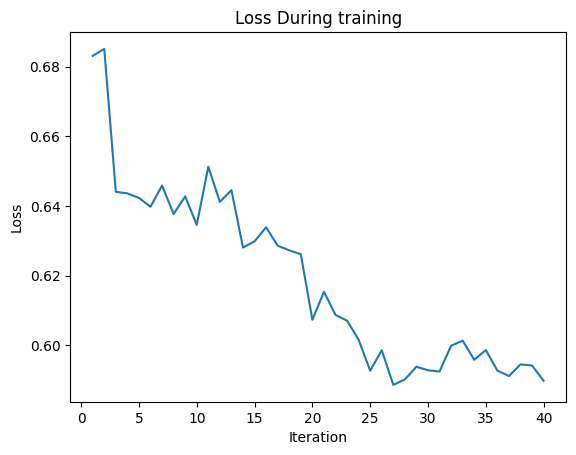

In [15]:
if is_local_simulator:
    lqm.plot_loss(losses_valid)
    plt.savefig(os.path.join(save_folder, "validation_loss.png"))

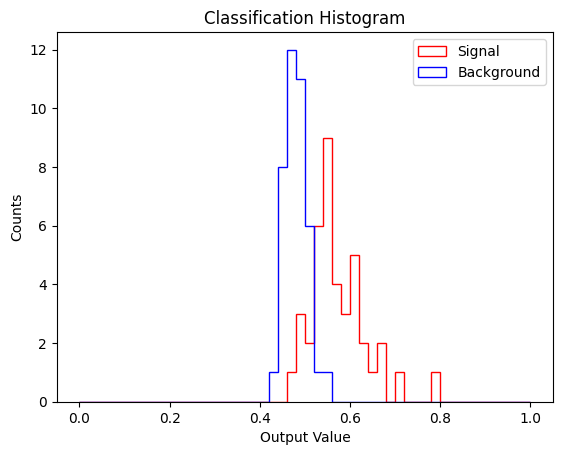

In [16]:
lqm.plot_class_hist(probs_test, test_labels)
plt.savefig(os.path.join(save_folder, "classhist.png"))

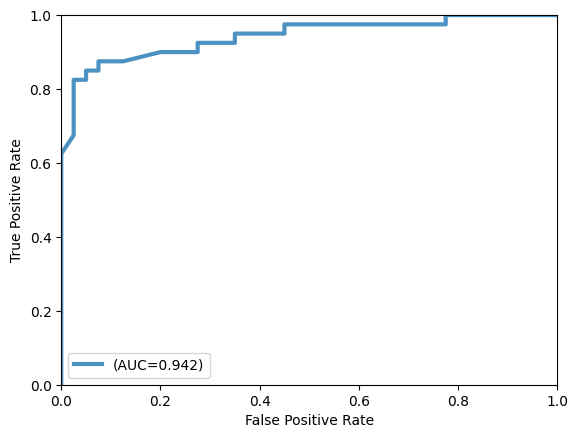

In [17]:
lqm.plot_roc(probs_test, test_labels)
plt.savefig(os.path.join(save_folder, "roc.png"))







| | predict 0 | predict 1|
|---|---|---|
|true 0|  32 | 8 |
|true 1|  4 | 36 |


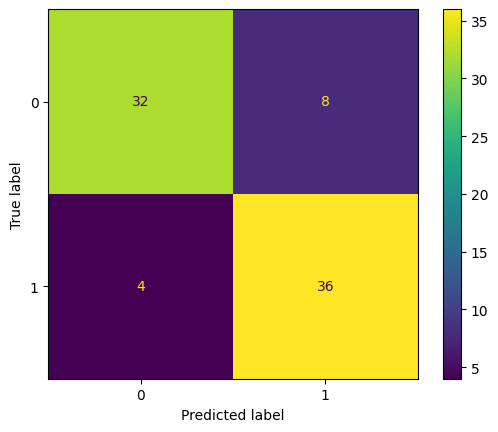

In [18]:
cm = confusion_matrix(test_labels, preds_test)
ConfusionMatrixDisplay(cm).plot()

print("\n\n\n\n\n")

# also print a table in the markdown format
print("| | predict 0 | predict 1|")
print("|---|---|---|")
print(f"|true 0|  {cm[0, 0]} | {cm[0, 1]} |")
print(f"|true 1|  {cm[1, 0]} | {cm[1, 1]} |")

In [19]:
print("\n\n\n\n\n")


print("| range | n signal | n background | percentage signal  | percentage background|")
print("|---|---|---|---|---|")

cuts = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


for cut in cuts:
    filter = (probs_test > cut)
    filtered_labels = test_labels[filter]

    n_total = len(filtered_labels)
    n_signal = np.sum(filtered_labels).astype(int)
    n_background = n_total-n_signal
    
    per_signal = n_signal/n_total * 100
    per_background = n_background/n_total * 100

    print(f"| >{cut:.1f} | {n_signal} | {n_background} | {per_signal:.1f}%  |  {per_background:.1f}% | ")









| range | n signal | n background | percentage signal  | percentage background|
|---|---|---|---|---|
| >0.4 | 40 | 40 | 50.0%  |  50.0% | 
| >0.5 | 36 | 8 | 81.8%  |  18.2% | 
| >0.6 | 12 | 0 | 100.0%  |  0.0% | 
| >0.7 | 2 | 0 | 100.0%  |  0.0% | 
| >0.8 | 0 | 0 | nan%  |  nan% | 
| >0.9 | 0 | 0 | nan%  |  nan% | 


/var/folders/fj/c2fmbjm91p3dkw_8qls_6y900000gn/T/ipykernel_61847/3221164460.py:18: RuntimeWarning: invalid value encountered in long_scalars
  per_signal = n_signal/n_total * 100
/var/folders/fj/c2fmbjm91p3dkw_8qls_6y900000gn/T/ipykernel_61847/3221164460.py:19: RuntimeWarning: invalid value encountered in long_scalars
  per_background = n_background/n_total * 100


In [20]:
probs_test

array([0.61816406, 0.515625  , 0.46679688, 0.47363281, 0.60644531,
       0.47265625, 0.49707031, 0.53613281, 0.49121094, 0.48730469,
       0.47167969, 0.49414062, 0.48632812, 0.60253906, 0.453125  ,
       0.5546875 , 0.48730469, 0.45800781, 0.453125  , 0.46386719,
       0.53417969, 0.54101562, 0.79296875, 0.55175781, 0.51074219,
       0.50488281, 0.57714844, 0.59570312, 0.42871094, 0.47949219,
       0.49316406, 0.4609375 , 0.53027344, 0.56933594, 0.65234375,
       0.49804688, 0.54199219, 0.52832031, 0.45214844, 0.52734375,
       0.63378906, 0.45410156, 0.46972656, 0.50488281, 0.49121094,
       0.57421875, 0.50488281, 0.54101562, 0.47363281, 0.59277344,
       0.484375  , 0.55859375, 0.47363281, 0.48339844, 0.48730469,
       0.54003906, 0.5390625 , 0.47265625, 0.62011719, 0.55859375,
       0.45800781, 0.50488281, 0.45703125, 0.54101562, 0.57910156,
       0.52246094, 0.59765625, 0.60644531, 0.50878906, 0.54394531,
       0.51367188, 0.61328125, 0.47460938, 0.4921875 , 0.67578